## Post process analysis
- Load the turn by turn data
- Emittance evolution 
- Tune shift with amplitude

In [1]:
import os
import sys
import numpy as np
from math import *
import matplotlib.pyplot as plt
import pandas as pd
from dotted_dict import DottedDict
import pickle
import PyNAFF as pnf
sys.path.append('./utils')
from my_functions import *

### Plotting parameters

In [2]:
params = {'legend.fontsize': 12,
          'figure.figsize': (8.5, 6.5),
          'axes.labelsize': 18,
          'axes.titlesize': 18,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}


plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

### Study parameters

In [3]:
f_rev = 11.2455e3  # revolution frequency [Hz]
# Relativistic parameters
gamma_rel = 7460.52252807237 # from madx twiss
beta_rel = sqrt(1-(1/gamma_rel)**2)
# Twiss parameters
twiss = DottedDict()
twiss.beta_x = 115.75 #at IP3 #obtained from madx twiss. should be crossed check
twiss.beta_y = 1. 
twiss.alpha_x = 0 
twiss.alpha_y = 0 
twiss.gamma_x = (1+twiss.alpha_x**2)/twiss.beta_x
twiss.gamma_y = (1+twiss.alpha_y**2)/twiss.beta_y
ex_norm = 2.5e-6
ex_geom = ex_norm/(beta_rel*gamma_rel)
#ex_geom = 0.047#*1e-9 #for SCC
sigma_x = sqrt(twiss.beta_x*ex_geom)
sigma_px = sqrt(ex_geom/twiss.beta_x)
print(sigma_x, sigma_px)
particles = 15000
turns = 1000

0.00019694541882215593 1.7014723008393603e-06


### Parameters of interest, in beam sigma px

In [4]:
Delta_values = [0.025, 0.05, 0.1] ## BB parameter
ksi_values = [1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 7e-2, 1e-1, 0.25, 0.3, 0.5] ## Strength of the noise
gain = 0.2

### Calculate the emittance values with time for each one of the studies

In [5]:
ex_dictionary = {}

for Delta_value in Delta_values:
    for ksi_value in ksi_values:
        df = pd.read_pickle('./turn_by_turn_data/Qx0.78_noise{}_BB{}_feedback0.2_betax115.75_H_particles15000_turns1000.pkl'.format(Delta_value, ksi_value))
        ex_dictionary['Noise'+str(Delta_value)+ '_BB'+str(ksi_value)] = [] # the name of the list on the dicitonary indicates the values of the BB parameter and of the strength noise
        for turn in range(turns):
            ex_dictionary['Noise'+str(Delta_value)+ '_BB'+str(ksi_value)].append(cmp_emit(df.at[turn,'x']/sqrt(twiss.beta_x), df.at[turn,'px']*sqrt(twiss.beta_x) ))

### Apply linear fit at the emitance values of each study.
During the first turns a flactuation of the emittance values is observed due to mismatched beam. Therfore the first 200 turns are excluded from the fit

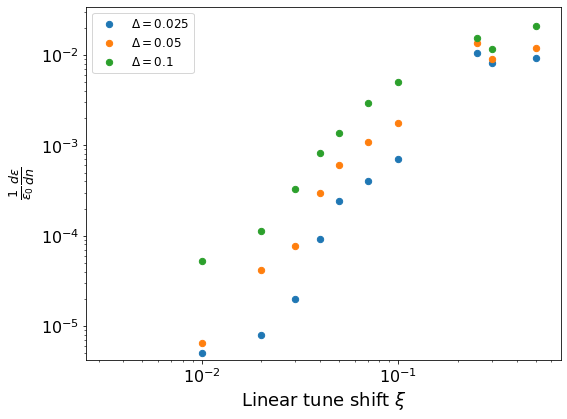

In [9]:
fig, ax = plt.subplots()

turns_list = np.arange(0,turns)

for Delta_value in Delta_values:
    growth_rate = [] 
    for ksi_value in ksi_values:
        current_study = ex_dictionary['Noise'+str(Delta_value)+ '_BB'+str(ksi_value)]
        [m_h,b_h], cov_h = np.polyfit(turns_list, current_study/current_study[0], 1, cov= True)
        growth_rate.append(m_h)
    ax.scatter(ksi_values, growth_rate, label = r'$\Delta =$'+ str(Delta_value), s = 40)
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('Linear tune shift ' + r'$\xi$')
    ax.set_ylabel(r'$\frac{1}{\epsilon_0} \frac{d\epsilon}{dn}$', fontsize = 25)
    
plt.legend()


### Compare emittance growth rate with the expected rate

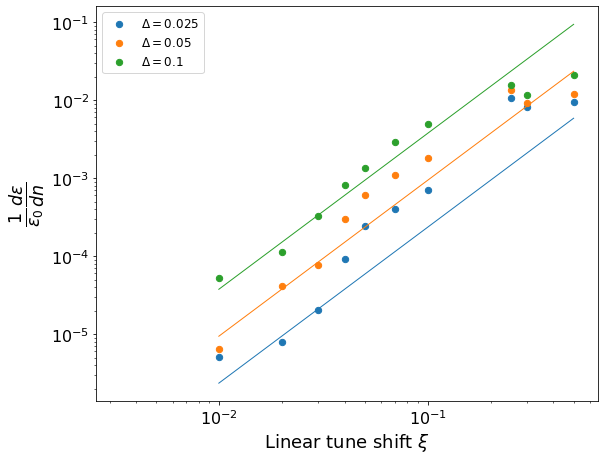

In [18]:
fig, ax = plt.subplots()

turns_list = np.arange(0,turns)
A =3.  # The fit parameter (p.168)

for Delta_value in Delta_values:
    growth_rate = [] 
    theory_rate = []
    for ksi_value in ksi_values:
        current_study = ex_dictionary['Noise'+str(Delta_value)+ '_BB'+str(ksi_value)]
        [m_h,b_h], cov_h = np.polyfit(turns_list, current_study/current_study[0], 1, cov= True)
        growth_rate.append(m_h)
        theory_rate.append(A*((ksi_value**2)*((Delta_value**2))/(2*gain**2)))
    ax.scatter(ksi_values, growth_rate, label = r'$\Delta =$'+ str(Delta_value), s = 40)
    ax.plot(ksi_values, theory_rate)

ax.axvline(x=0.03, ymin=0, ymax=1, linestyle =  '--', c = 'k', label = r'$\xi = 0.03$')
        
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Linear tune shift ' + r'$\xi$')
ax.set_ylabel(r'$\frac{1}{\epsilon_0} \frac{d\epsilon}{dn}$', fontsize = 25)
    
plt.tight_layout()
plt.legend()
#lt.savefig('emittance_growth_rate_Qx0.78_noisescan_BBscan_feedback0.2_betax115.75_H_particles15000_turns1000_v1.png')

/home/natalia/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/natalia/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/natalia/anaconda2/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


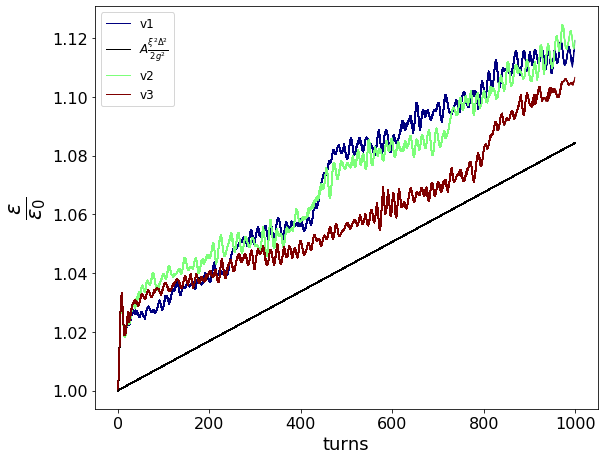

In [12]:
import matplotlib
fig, ax = plt.subplots()

jet = plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,1,len(studies_names))))

turns_list = np.arange(0,1000)

# Parametrs of the study
Delta = 0.05#*sigma_px
gain = 0.2#*sigma_px
A =3  #p.168
ksi = 0.03#*sigma_px

turns_list = np.arange(0,turns)
theory_rate = A*((ksi**2)*((Delta**2))/(2*gain**2))


for index, study in enumerate(studies_names) :
    c1 = next(colors)
    df  = pd.read_pickle('./turn_by_turn_data/{}'.format(study))
    e_x = [] # list for the values of geometric emittance over turns
    for turn in range(turns):
        e_x.append(cmp_emit(df.at[turn,'x']/sqrt(twiss.beta_x), df.at[turn,'px']*sqrt(twiss.beta_x) ))
        if turn == 1:
            ax.plot(e_x/e_x[0], c = c1, label = variables_string_list[index])
            if study == studies_names[0]:
                plt.plot(turns_list, 1 + theory_rate*turns_list, label = r'$A\frac{\xi^2 \Delta^2}{2g^2} $', c = 'k')
            #ax.plot(e_x/e_x[0], c = c1, label = r'$Q_x$='+str(variables_list[index]))
        else:
            ax.plot(e_x/e_x[0], c = c1)
            plt.plot(turns_list, 1 + theory_rate*turns_list, c = 'k')
ax.set_xlabel('turns')
ax.set_ylabel(r'$\frac{\epsilon}{\epsilon_{0}}$',fontsize = 30)
#plt.ylabel(r'$\epsilon [m]}$',fontsize = 30)
#plt.ylim(-1.000025, 1.000025)
y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
ax.yaxis.set_major_formatter(y_formatter)
plt.legend()
plt.tight_layout()
plt.savefig('./figures/emittances_test.png')

### Neglet the first 100 turns

No handles with labels found to put in legend.
/home/natalia/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/natalia/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/natalia/anaconda2/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


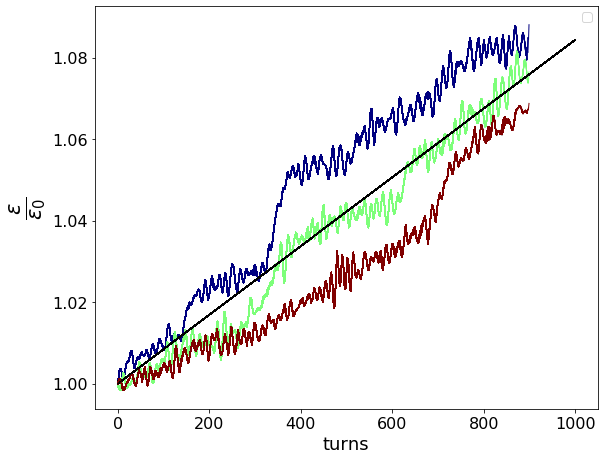

In [13]:
import matplotlib
fig, ax = plt.subplots()

jet = plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,1,len(studies_names))))
#variables_list = [0.837, 0.845, 0.85]

excluded_turns = 100
turns_list_v2 = np.arange(0,turns- excluded_turns)


# Parametrs of the study
Delta = 0.05#*sigma_px
gain = 0.2#*sigma_px
A =3  #p.168
ksi = 0.03#*sigma_px

turns_list = np.arange(0,turns)
theory_rate = A*((ksi**2)*((Delta**2))/(2*gain**2))


for index, study in enumerate(studies_names) :
    c1 = next(colors)
    df  = pd.read_pickle('./turn_by_turn_data/{}'.format(study))
    e_x = [] # list for the values of geometric emittance over turns
    for turn in range(100, turns):
        e_x.append(cmp_emit(df.at[turn,'x']/sqrt(twiss.beta_x), df.at[turn,'px']*sqrt(twiss.beta_x) ))
        if turn == 1:
            ax.plot(e_x/e_x[0], c = c1, label = variables_string_list[index])
            if study == studies_names[0]:
                plt.plot(turns_list, 1 + theory_rate*turns_list, label = r'$A\frac{\xi^2 \Delta^2}{2g^2} $', c = 'k')
            #ax.plot(e_x/e_x[0], c = c1, label = r'$Q_x$='+str(variables_list[index]))
        else:
            ax.plot(e_x/e_x[0], c = c1)
            plt.plot(turns_list, 1 + theory_rate*turns_list, c = 'k')
ax.set_xlabel('turns')
ax.set_ylabel(r'$\frac{\epsilon}{\epsilon_{0}}$',fontsize = 30)
#plt.ylabel(r'$\epsilon [m]}$',fontsize = 30)
#plt.ylim(-1.000025, 1.000025)
y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
ax.yaxis.set_major_formatter(y_formatter)
plt.legend()
plt.tight_layout()
plt.savefig('./figures/emittances_test.png')